In [231]:
import pickle, sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
sys.path.append('../toolbox/')
from flir_toolbox import *


c:\Users\armor\OneDrive - Rensselaer Polytechnic Institute\thesis_work\Code\Welding_Motoman\FLIR\../toolbox\flir_toolbox.py:30: RuntimeWarning: invalid value encountered in log
  data_temp = (B / np.log(R/((K1 * data_obj_signal) - K2) + F)) -273.15


True
(240, 320)


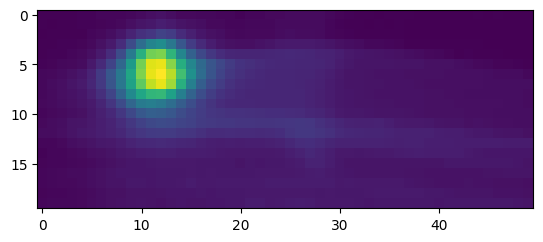

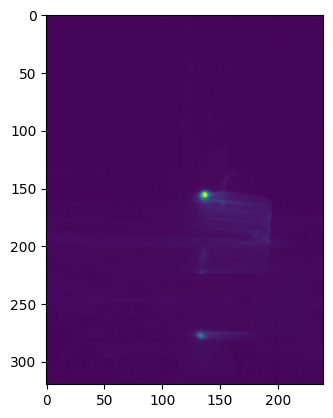

In [252]:
with open('../../recorded_data/weld_scan_job205_v102023_07_27_12_16_49/layer_180/ir_recording.pickle', 'rb') as file:
    ir_recording = pickle.load(file)

# with open('../../recorded_data/weld_scan_job205_v152023_07_27_13_23_06/layer_150/ir_recording.pickle', 'rb') as file:
#     ir_recording = pickle.load(file)

max_val = np.max(ir_recording)
min_val = np.min(ir_recording)

ir_recording_temp = counts2temp(ir_recording,6.39661118e+03, 1.40469989e+03, 1.00000008e+00, 8.69393436e+00, 8.40029488e+03,Emiss=0.13)
print(np.any(np.isnan(ir_recording_temp)))
window_size_x = 50
window_size_y = 20
window_x = 125
window_y = 150
print(ir_recording_temp[0].shape)
plt.imshow(ir_recording_temp[200, window_x:window_x+window_size_x, window_y:window_y+window_size_y,].T)
plt.show()
plt.imshow(ir_recording_temp[200].T)

(1000, 200)


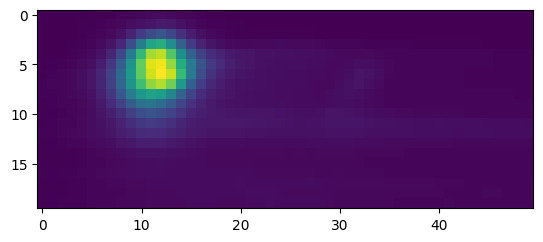

In [253]:
ir_frames = ir_recording[150:350, window_x:window_x+window_size_x, window_y:window_y+window_size_y]

M = ir_frames.shape[1]
N = ir_frames.shape[2]
vec_frames = np.zeros((M*N, ir_frames.shape[0]))
for idx,frame in enumerate(ir_frames):
    vec_frames[:,idx] = np.reshape(frame, (M*N))
print(vec_frames.shape)
plt.imshow(np.reshape(vec_frames[:,100], (M,N)).T)


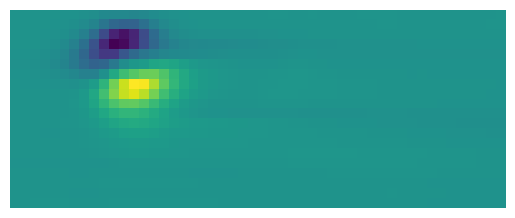

1000000


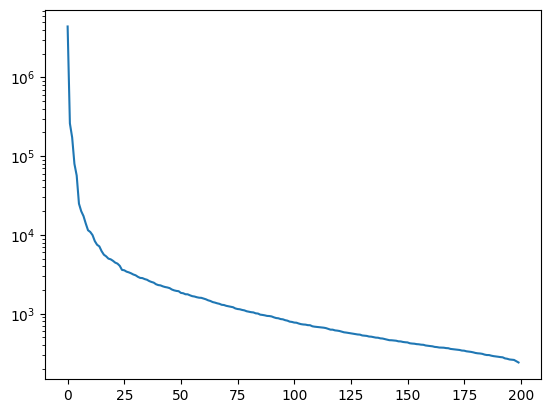

In [261]:
[U, S_list, V] = np.linalg.svd(vec_frames)

S = np.diag(S_list)
fig,ax = plt.subplots(1,1)
ax.imshow(np.reshape(-U[:,1], (M,N)).T)
ax.axis('off')
plt.show()
print(U.size)

plt.plot(S_list)
plt.yscale('log')
plt.show()

In [235]:
size = len(S)
sum_sin = np.sum(np.square(S))

squared_frob = np.zeros(size)

flag_9 = True
flag_99 = True
flag_999 = True

for r in range(1,size):
    U_r = U[:,:r]
    S_r = S[:r,:r]
    V_r = V[:r,:]

    #Reconstruction
    recon_series = U_r@S_r@V_r

    percent_energy = (np.sum(np.square(S_r)))/sum_sin

    

    if percent_energy >= 0.9 and flag_9: 
        print("90% r: ", r)
        flag_9 = False
    if percent_energy >=0.99 and flag_99: 
        print("99% r: ", r)
        flag_99 = False
    if percent_energy >=0.999 and flag_999:
        print("99.9% r: ", r)
        flag_999= False

    #squared_frob[r] = np.linalg.norm(ir_frames-recon_series)**2

90% r:  1
99% r:  1
99.9% r:  3


(1000, 193)


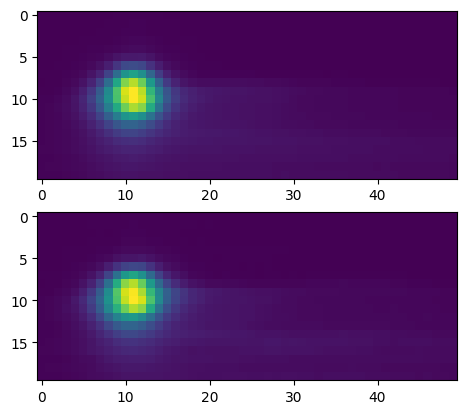

In [236]:
# image reconstruction
r = 4
U_r = U[:,:r]
S_r = S[:r,:r]
V_r = V[:r,:]

recon_series = U_r@S_r@V_r
print(recon_series.shape)

img_num = 100
fig, ax = plt.subplots(2,1)
ax[0].imshow(np.reshape(recon_series[:,img_num], (M,N)).T)
ax[1].imshow(np.reshape(vec_frames[:,img_num], (M,N)).T)

In [237]:
scale = np.max(ir_frames)

cv2.imwrite('image.png', ir_frames[0]/scale*255)

out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 15, (M,N), isColor=False)
for f in vec_frames.T:
    frame = f.reshape(M,N)/scale*256
    frame = frame.astype(np.uint8)
    out.write(frame.T)
out.release()

MovieWriter PillowWritter unavailable; using Pillow instead.


(1000, 193)


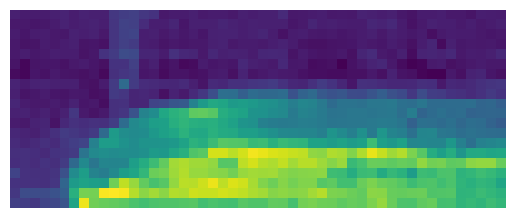

In [238]:
fig,ax = plt.subplots()
print(vec_frames.shape)

def update(i):
     frame = vec_frames[:,i].reshape(M,N).T
     ax.imshow(frame)
     ax.set_axis_off()
anim = FuncAnimation(fig, update, frames=vec_frames.shape[1], interval=50)
anim.save('animation.gif',writer='PillowWritter', fps = 10)
#fig.show()